In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import pickle
import pandas as pd
import itertools
from scipy import optimize
import xarray as xr     

#local import
import akross_common_functions as AK
from smrt.permittivity.saline_snow import saline_snow_permittivity_scharien_with_stogryn95 as ssp
from smrt import make_model
from smrt.inputs import altimeter_list
from smrt.emmodel.iba import derived_IBA

#turn off warning
import warnings
warnings.simplefilter('ignore')
pd.set_option('mode.chained_assignment',None)

This notebook contains the following 4 sections

1. Align observation of waveform
2. prepare snowpack for simulation
3. Normalisation factor and roughness optimization
4. Simulation and observation comparison

### 1. Align Observation of Waveform

Import observation form pickle file and align to nominal gate of simulation.

In [2]:
#get obs
with open('smrt_in-out/observed_waveform_cb22', 'rb') as pickle_file:
    obs_CB = pickle.load(pickle_file)
with open('smrt_in-out/observed_waveform_E22', 'rb') as pickle_file:
    obs_E22 = pickle.load(pickle_file)
with open('smrt_in-out/observed_wave_Eureka_Alert', 'rb') as pickle_file:
    obs_E_A = pickle.load(pickle_file)

#Align waveform
#CB already done
mean_obs_CB = obs_CB['mean']
#E22 already done
mean_obs_E22 = obs_E22['mean']

#Align waveform
new_obs_E = [AK.align_waveform_with_sim(wave) for wave in obs_E_A['eureka']]
new_obs_A = [AK.align_waveform_with_sim(wave) for wave in obs_E_A['alert']]
mean_obs_E = np.mean(new_obs_E, axis = 0)
mean_obs_A = np.mean(new_obs_A, axis = 0)

(130.0, 250.0)

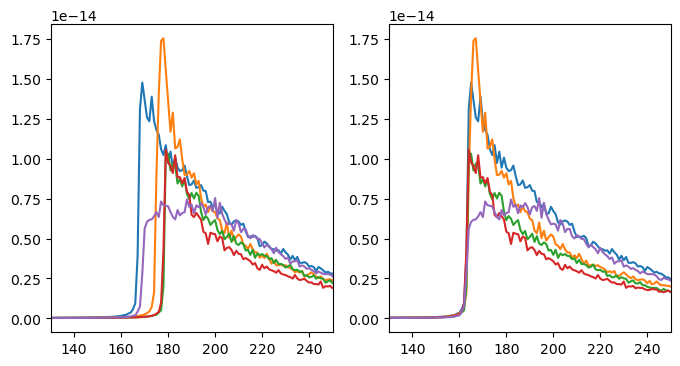

In [3]:
#Show exemple of alignement

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,4))
for i in range(0,len(obs_E_A['eureka'])):
    ax[0].plot(obs_E_A['eureka'][i])
ax[0].set_xlim(130,250)

for i in range(0,len(new_obs_E)):
    ax[1].plot(new_obs_E[i])
ax[1].set_xlim(130,250)

### 2. Prepare snowpack for simulation

- import profile derived from smp ready to inpu in SMRT simulation
- CB and Eureka22 have special pickle file of profile already prepare for input for SMRT. Pre processing was done to put smp density, ssa wiuth temperature and salinity from pit. For Eureak 16 and Alert, only smp density and ssa is used. Temperature and salinity is set to a constant. For Eureka 16 and Alert, data can be downloaded from 


In [4]:
#get smp profile for CB
with open('smrt_in-out/smp_profile_CB_3cm', 'rb') as pickle_file:
    smp_CB = pickle.load(pickle_file)

#Get smp from Eureka22
with open('smrt_in-out/smp_profile_E22_3cm', 'rb') as pickle_file:
    list_profile_E22 = pickle.load(pickle_file)

#restructure to list of profile
# Flatten dict of dicts
list_profile_CB = [profile for site, item in smp_CB.items() for name, profile in item.items()]


# create list of SMRT snpwpack
CB_sp = AK.build_snowpack_pickle(list_profile_CB, ice_salinity = 5, ice_temp = 260, sea_ice_density = 910, ice_type = 'firstyear')
E22_sp = AK.build_snowpack_pickle(list_profile_E22, ice_salinity = 5, ice_temp = 260, sea_ice_density = 910, ice_type = 'firstyear')

type(E22_sp[0])

smrt.core.snowpack.Snowpack

In [5]:
# Get list of sites (upper folders)
# Data from https://doi.org/10.5281/zenodo.4068349
#data_dir = '../DATA/SMP/Sites'
data_dir = 'C:/Users/melochej/Documents/code-workshop/AKROSS/DATA/SMP/Sites'
list_of_sites = os.listdir(path=data_dir)
# Split Eureka and Alert sites
eureka_sites = [s for s in list_of_sites if 'Eureka' in s]
alert_sites = [s for s in list_of_sites if 'Alert' in s]

E_smp_files = []
for s in eureka_sites:
    E_smp_files.append(AK.find_site_smp_files(s, data_dir = data_dir))
# Flatten list of lists
all_eureka = list(itertools.chain(*E_smp_files))
# Remove all non .pnt files (NB some are .PNT)
eureka_smp_files = [s for s in all_eureka if 'pnt' in s.lower()]


A_smp_files = []
for s in alert_sites:
    A_smp_files.append(AK.find_site_smp_files(s, data_dir = data_dir))
# Flatten list of lists
all_alert = list(itertools.chain(*A_smp_files))
# Remove all non .pnt files (NB some are .PNT)
alert_smp_files = [s for s in all_alert if 'pnt' in s.lower()]


# Creat SMRT snow pack
alert_salt = 1
eureka_salt = 3

E_sp = AK.smp_snowpacks(eureka_smp_files, layer_thickness=0.03, rough=False, permittivity = None,
                           sigma_surface = 0.3, snow_salt = eureka_salt)
#E_myi_sp = AK.smp_snowpacks(eureka_smp_myi_files, rough=False)
A_sp = AK.smp_snowpacks(alert_smp_files, layer_thickness=0.03, rough=False, permittivity = None, 
                        sea_ice_density=880, sigma_surface = 0.3, snow_salt = alert_salt)

make snowpack failed for C:/Users/melochej/Documents/code-workshop/AKROSS/DATA/SMP/Sites/Eureka_4_FYI/S34M0496.pnt
make snowpack failed for C:/Users/melochej/Documents/code-workshop/AKROSS/DATA/SMP/Sites/Eureka_5_MYI/S34M0676.pnt


In [8]:
print(f' Number of snowpack (or simulation) for CB : {len(CB_sp)},  Alert : {len(A_sp)}, Eureka 16 : {len(E_sp)}, Eureka 22 : {len(E22_sp)}')

 Number of snowpack (or simulation) for CB : 109,  Alert : 63, Eureka 16 : 550, Eureka 22 : 87


In [9]:
E_sp[10]

Snowpack:        layer                                                            \
   thickness microstructure_model     density temperature liquid_water   
0     0.0300          Exponential  165.748352       260.0          0.0   
1     0.0300          Exponential  165.888259       260.0          0.0   
2     0.0300          Exponential  168.073804       260.0          0.0   
3     0.0300          Exponential  168.233081       260.0          0.0   
4     0.0300          Exponential  169.184512       260.0          0.0   
5     0.0300          Exponential  271.822247       260.0          0.0   
6     0.0300          Exponential  449.013100       260.0          0.0   
7     0.0300          Exponential  442.126605       260.0          0.0   
8     0.0300          Exponential  445.643975       260.0          0.0   
9     0.0375          Exponential  393.300494       260.0          0.0   
10    2.0000    IndependentSphere  910.000000       260.0          NaN   
s        NaN                  NaN         NaN         NaN          NaN   

                       microstructure                    interface substrate  
   salinity   ice_type    frac_volume corr_length radius      name      name  
0     0.000       None       0.180810    0.000074    NaN      Flat       NaN  
1     0.000       None       0.180962    0.000074    NaN      Flat       NaN  
2     0.000       None       0.183347    0.000073    NaN      Flat       NaN  
3     0.000       None       0.183520    0.000074    NaN      Flat       NaN  
4     0.000       None       0.184558    0.000074    NaN      Flat       NaN  
5     0.000       None       0.296523    0.000095    NaN      Flat       NaN  
6     0.000       None       0.489815    0.000072    NaN      Flat       NaN  
7     0.000       None       0.482302    0.000072    NaN      Flat       NaN  
8     0.000       None       0.486139    0.000071    NaN      Flat       NaN  
9     0.003       None       0.429039    0.000093    NaN      Flat       NaN  
10    0.005  firstyear       0.022608         NaN  0.001      Flat       NaN  
s       NaN        NaN            NaN         NaN    NaN       NaN      Flat

### 3. Find norm factor for rough surfaces

In [10]:
#set mean roughness value for snow and ice from AKROSS campaign outside of opti for the norm factor

#ice
mean_ice_lc = 0.15
#snow
mean_snow_rms = 0.0039
mean_snow_lc = 0.16

In [12]:
def opti_normf(ice_rms, rough_model):
    """
    evaluate the value of the norm factor as afunction of ice roughness (rms) for two different surface model.
    ice_rms : ice roughness, float
    rough_model :  either 'IEM' our 'Geo'
    return norm factor
    """
    if rough_model == 'IEM':
        AK.change_roughness(A_sp, ice_rms, mean_ice_lc, mean_snow_rms, mean_snow_lc)
        AK.change_roughness(E_sp, ice_rms, mean_ice_lc, mean_snow_rms, mean_snow_lc)
        AK.change_roughness(CB_sp, ice_rms, mean_ice_lc, mean_snow_rms, mean_snow_lc)
        AK.change_roughness(E22_sp, ice_rms, mean_ice_lc, mean_snow_rms, mean_snow_lc)
        
    if rough_model == 'Geo':
        AK.change_roughness_geo(A_sp, ice_rms, mean_ice_lc, mean_snow_rms, mean_snow_lc, interface = 'ice')
        AK.change_roughness_geo(E_sp, ice_rms, mean_ice_lc, mean_snow_rms, mean_snow_lc, interface = 'ice')
        AK.change_roughness_geo(CB_sp, ice_rms, mean_ice_lc, mean_snow_rms, mean_snow_lc, interface = 'ice')
        AK.change_roughness_geo(E22_sp, ice_rms, mean_ice_lc, mean_snow_rms, mean_snow_lc, interface = 'ice')

    altimodel = make_model("iba", "nadir_lrm_altimetry", rtsolver_options=dict(theta_inc_sampling=8))
    cryosat = altimeter_list.cryosat2_sin()
    res_A = altimodel.run(cryosat, A_sp).sigma()
    res_E = altimodel.run(cryosat, E_sp).sigma()
    res_CB = altimodel.run(cryosat, CB_sp).sigma()
    res_E22 = altimodel.run(cryosat, E22_sp).sigma()

    mean_simu_A = np.mean(res_A, axis = 0)
    mean_simu_E = np.mean(res_E, axis = 0)
    mean_simu_CB = np.mean(res_CB, axis = 0)
    mean_simu_E22 = np.mean(res_E22, axis = 0)
    
    obs = np.array([AK.calc_A(mean_obs_E), AK.calc_A(mean_obs_A),  AK.calc_A(mean_obs_CB), AK.calc_A(mean_obs_E22)])
    sim = np.array([AK.calc_A(mean_simu_E), AK.calc_A(mean_simu_A),  AK.calc_A(mean_simu_CB), AK.calc_A(mean_simu_E22)])
    cryosat_norm_factor = AK.normalization_factor(sim, obs)
    
    return cryosat_norm_factor


In [13]:
# find limit of surface model
k = 2*np.pi*13.575e9/3e8
s_k_geo = 1/k
s_k_iem = 3/k

#define roughness to evaluate for the two model
rms_iem_array = np.logspace(-4, np.log10(s_k_iem))
rms_geo_array = np.logspace(np.log10(s_k_geo), -1, 30)

In [14]:
#find maximum of the curve
#normf_rms_geo = [opti_normf(rms, 'Geo') for rms in rms_geo_array]
normf_rms_iem = [opti_normf(rms, 'IEM') for rms in rms_iem_array]
#index = np.argmax((normf_rms_iem + normf_rms_geo))
index = np.argmax((normf_rms_iem))
rms_iem_array[index]

Warning, roughness_rms is too high for the given wavelength. Limit is ks < 3. Here ks=3.03279
Warning, roughness_rms is too high for the given wavelength. Limit is ks < 3. Here ks=3.02253
Warning, roughness_rms is too high for the given wavelength. Limit is ks < 3. Here ks=3.03536
Warning, roughness_rms is too high for the given wavelength. Limit is ks < 3. Here ks=3.01937
Warning, roughness_rms is too high for the given wavelength. Limit is ks < 3. Here ks=3.02298
Warning, roughness_rms is too high for the given wavelength. Limit is ks < 3. Here ks=3.06553
Warning, roughness_rms is too high for the given wavelength. Limit is ks < 3. Here ks=3.0469
Warning, roughness_rms is too high for the given wavelength. Limit is ks < 3. Here ks=3.03902
Warning, roughness_rms is too high for the given wavelength. Limit is ks < 3. Here ks=3.01055
Warning, roughness_rms is too high for the given wavelength. Limit is ks < 3. Here ks=3.01477
Warning, roughness_rms is too high for the given wavelength. 

0.0019057299752474814

In [15]:
# #plot the normf curve as a function of roughness, show limit of model as well

# plt.figure(figsize = (8,4))
# plt.rcParams.update({'font.size': 14})
# plt.plot(rms_iem_array, normf_rms_iem, label = 'IEM', color = 'dodgerblue')
# plt.plot(rms_geo_array, normf_rms_geo, label = 'Geo optic', color = 'orange')
# plt.vlines(s_k_geo, 0, max(normf_rms_iem), linestyle = ':', color = 'orange', label = 'ks = 1')
# plt.vlines(s_k_iem, 0, max(normf_rms_iem), linestyle = ':', color = 'dodgerblue', label = 'ks = 3')
# plt.fill_between(rms_iem_array, 0, max(normf_rms_iem), color = 'dodgerblue', alpha = 0.2)
# plt.fill_between(rms_geo_array, 0, max(normf_rms_iem), color = 'orange', alpha = 0.2)
# plt.xlabel('$s_{ice}$ (m)')
# plt.ylabel('Normalization factor')
# plt.xscale('log')
# plt.legend()
# plt.grid()
# #plt.savefig('C://Users/julie/OneDrive - USherbrooke/post-doc/AKROSS/article/fig_output/normf_roughness.png', dpi=300, format='png', bbox_inches='tight')

In [16]:
#optimized normf
# set norm factor for the rest of simulation
cryosat_norm_factor =  normf_rms_iem[index]
#set rouhgness associated with norm factor
rms_normf_opti = rms_iem_array[index] 

cryosat_norm_factor

1.2174888715277877e-09

Optimization of the roughness

In [17]:
# def simulate_waveform(p, sp):
#     """
#     set mean roughness value for snow and ice from AKROSS campaign
#     """
    
#     AK.change_roughness(sp, p[0], p[1], mean_snow_rms, mean_snow_lc)
        
#     altimodel = make_model(derived_IBA(ssp), "nadir_lrm_altimetry", rtsolver_options=dict(theta_inc_sampling=8))
#     cryosat = altimeter_list.cryosat2_sin()
#     res = altimodel.run(cryosat, sp, parallel_computation=True).sigma()

#     mean_simu = np.mean(res, axis = 0).values / cryosat_norm_factor

#     return mean_simu

# def log_waveform_residual(p, sp, obs):
#     """
#     this is the least squares residual function for 
#     log transformed data
#     index 160 so skip the noise part of the waveform
#     """
#     #return simulate_waveform(p, sp)[160:-50] - obs[160:-50]
#     return np.log(simulate_waveform(p, sp)[160:-50]) - np.log(obs[160:-50])

# # def waveform_residual(sim, obs):
# #     """
# #     this is the least squares residual function for 
# #     log transformed data
# #     index 160 so skip the noise part of the waveform
# #     """
# #     #return simulate_waveform(p, sp)[160:-50] - obs[160:-50]
# #     return np.mean((sim[160:-50] - obs[160:-50])**2/ obs[160:-50])

# def optimize_rough(sp, obs, p0):
#     """ 
#     optimize using least sqaure the two rough parameters per sites
#     """

#     # set bounds. helpful to constrain the otherwise difficult nonlinear optimization,

#     bounds=([0.0001, 0.01], 
#             [0.07, 0.6] )


#     # least squares, use log transformed data, since the waveform contains values
#     # separated by several orders of magnitude
#     aux = optimize.least_squares(log_waveform_residual, 
#                                     p0, 
#                                     bounds=bounds, 
#                                     args=(sp, obs))

#     # get fit parameters
#     popt = aux.x
#     print(f'ice_rms : {popt[0]}, ice_lc : {popt[1]}, cost : {aux.cost}')

#     # calculate fit function
#     #P_fit = simulate_waveform(popt, sp)

#     return popt

In [18]:
# #run optimization for two different initial parameters for each site
# p0_b = np.array([0.0011,
#                 0.45 ])
# popt_CB_b = optimize_rough(CB_sp, mean_obs_CB, p0_b)
# popt_E22_b = optimize_rough(E22_sp, mean_obs_E22, p0_b)
# popt_E_b = optimize_rough(E_sp, mean_obs_E, p0_b)
# popt_A_b = optimize_rough(A_sp, mean_obs_A, p0_b)

# p0_w = np.array([0.0041,
#                 0.10 ])
# popt_CB_w = optimize_rough(CB_sp, mean_obs_CB, p0_w)
# popt_E22_w = optimize_rough(E22_sp, mean_obs_E22, p0_w)
# popt_E_w = optimize_rough(E_sp, mean_obs_E, p0_w)
# popt_A_w = optimize_rough(A_sp, mean_obs_A, p0_w)

In [126]:
def simulate_waveform(s, l, norm_f, sp):
    """
    set mean roughness value for snow and ice from AKROSS campaign
    """
    
    AK.change_roughness(sp, s, l, mean_snow_rms, mean_snow_lc)
        
    altimodel = make_model(derived_IBA(ssp), "nadir_lrm_altimetry", rtsolver_options=dict(theta_inc_sampling=8))
    cryosat = altimeter_list.cryosat2_sin()
    res = altimodel.run(cryosat, sp, parallel_computation=True).sigma()

    mean_simu = np.mean(res, axis = 0).values / norm_f

    return mean_simu

def log_waveform_residual(p, sp, obs):
    """
    this is the least squares residual function for 
    log transformed data
    index 160 so skip the noise part of the waveform
    """
    begin_index = 160
    end_index = -50

    res1 = np.log(simulate_waveform(p[0], p[1], p[8], sp[0])[begin_index:end_index]) - np.log(obs[0][begin_index:end_index])
    res2 = np.log(simulate_waveform(p[2], p[3], p[8], sp[1])[begin_index:end_index]) - np.log(obs[1][begin_index:end_index])
    res3 = np.log(simulate_waveform(p[4], p[5], p[8], sp[2])[begin_index:end_index]) - np.log(obs[2][begin_index:end_index])
    res4 = np.log(simulate_waveform(p[6], p[7], p[8], sp[3])[begin_index:end_index]) - np.log(obs[3][begin_index:end_index])

    return res1**2 + res2**2 + res3**2 + res4**2


def optimize_rough(sp, obs, p0):
    """ 
    optimize using least sqaure the two rough parameters per sites
    """

    # set bounds. helpful to constrain the otherwise difficult nonlinear optimization,

    bounds=([0.001, 0.01, 0.001, 0.01, 0.001, 0.01, 0.001, 0.01, 8e-10], 
            [0.01, 0.6, 0.01, 0.6, 0.01, 0.6, 0.01, 0.6, 4e-9])
   


    # least squares, use log transformed data, since the waveform contains values
    # separated by several orders of magnitude
    aux = optimize.least_squares(log_waveform_residual, 
                                    p0, 
                                    bounds=bounds,
                                    method ='trf',
                                    loss = 'soft_l1', 
                                    args=(sp, obs),
                                    verbose = 1)

    # get fit parameters
    popt = aux.x
    print(f'ice_rms : {popt[0]}, ice_lc : {popt[1]}')
    print(f'ice_rms : {popt[2]}, ice_lc : {popt[3]}')
    print(f'ice_rms : {popt[4]}, ice_lc : {popt[5]}')
    print(f'ice_rms : {popt[6]}, ice_lc : {popt[7]}')
    print(f'norm_factor : {popt[8]}')


    return popt


def log_waveform_residual_single(p, sp, obs, norm_f):
    """
    this is the least squares residual function for 
    log transformed data
    index 160 so skip the noise part of the waveform
    """
    begin_index = 160
    end_index = -50
    return np.log(simulate_waveform(p[0], p[1], norm_f, sp)[begin_index:end_index]) - np.log(obs[begin_index:end_index])

def optimize_rough_single(sp, obs, normf, p0):
    """ 
    optimize using least sqaure the two rough parameters per sites
    """

    # set bounds. helpful to constrain the otherwise difficult nonlinear optimization,

    bounds=([0.0008, 0.01], 
            [0.01, 0.6])
   


    # least squares, use log transformed data, since the waveform contains values
    # separated by several orders of magnitude
    aux = optimize.least_squares(log_waveform_residual_single, 
                                    p0, 
                                    bounds=bounds,
                                    method ='trf',
                                    loss = 'soft_l1', 
                                    args=(sp, obs, normf))

    # get fit parameters
    popt = aux.x
    print(f'ice_rms : {popt[0]}, ice_lc : {popt[1]}')

    return popt

In [127]:

p0 = np.array([ 0.0021, 0.15,
                0.0021, 0.15,
                0.0021, 0.15,
                0.0021, 0.15, 
                1e-9])
popt = optimize_rough([CB_sp, E22_sp, E_sp, A_sp], 
                           [mean_obs_CB, mean_obs_E22, mean_obs_E, mean_obs_A],
                            p0)


In [ ]:
print(f""" optimized roughness for
      CB : rms = {popt[0]}, l = {popt[1]}
      E22 : rms = {popt[2]}, l = {popt[3]}
      E16 : rms = {popt[4]}, l = {popt[5]}
      A : rms = {popt[6]}, l = {popt[7]} 
      Norm factor : {popt[8]}""")

 optimized roughness for
      CB : rms = 0.0013811521142908737, l = 0.4734448304860506
      E22 : rms = 0.027971763586348966, l = 0.07104954017306746
      E16 : rms = 0.03999794913682702, l = 0.06577062821005385
      A : rms = 0.039609067820325444, l = 0.06687214062995946 
      Norm factor : 8.000000000000001e-10


In [ ]:
# p0 = np.array([popt[0], popt[1], popt[2], popt[3], popt[4], popt[5], popt[6], popt[7]])
# popt = optimize_rough_normf(  [CB_sp, E22_sp, E_sp, A_sp], 
#                         [mean_obs_CB, mean_obs_E22, mean_obs_E, mean_obs_A],
#                         popt[8],
#                         p0)

In [ ]:
# popt_CB = (popt[0], popt[1])
# popt_E22 = (popt[2], popt[3])
# popt_E = (popt[4], popt[5])
# popt_A = (popt[6], popt[7])

cryosat_norm_factor = popt[8]


In [ ]:
p0 = np.array([popt[0], popt[1]])
popt_CB = optimize_rough_single(CB_sp, mean_obs_CB, cryosat_norm_factor, p0)
p0 = np.array([popt[2], popt[3]])
popt_E22 = optimize_rough_single(E22_sp, mean_obs_E22, cryosat_norm_factor, p0)
p0 = np.array([popt[4], popt[5]])
popt_E = optimize_rough_single(E_sp, mean_obs_E, cryosat_norm_factor, p0)
p0 = np.array([popt[6], popt[7]])
popt_A = optimize_rough_single(A_sp, mean_obs_A, cryosat_norm_factor, p0)

ice_rms : 0.0013421754720490636, ice_lc : 0.5999999999625002


ValueError: `x0` is infeasible.

In [ ]:
"""
generate opti cost function, pretty long to generate. Use save surface to generate plot or reduce resolution
"""
rms_array = np.arange(0.0001, 0.0062, 0.0005)
lc_array = np.arange(0.01, 0.62, 0.05)

# def run_fig_opti(sp, obs, rms_array, lc_array):
#     #figure opti
#     #define vectorize funstion
#     def vectorize_simu(rms_opti, lc_opti):
#         residual = log_waveform_residual([rms_opti, lc_opti], sp, obs)
#         return np.sum(residual**2)

#     #vectorize function
#     vfunc = np.vectorize(vectorize_simu) 

#     rms_matrix = np.full((len(rms_array), len(lc_array)), rms_array)
#     lc_matrix = np.full((len(rms_array), len(lc_array)), lc_array[::-1])

#     return vfunc(rms_matrix, np.transpose(lc_matrix))

# result_CB = run_fig_opti(CB_sp, mean_obs_CB, rms_array, lc_array)
# result_E22 = run_fig_opti(E22_sp, mean_obs_E22, rms_array, lc_array)
# result_E = run_fig_opti(E_sp, mean_obs_E, rms_array, lc_array)
# result_A = run_fig_opti(A_sp, mean_obs_A, rms_array, lc_array)


# ds_CB = xr.DataArray(result_CB, coords = [rms_array, lc_array], dims = ['rms', 'lc'])
# ds_E22 = xr.DataArray(result_E22, coords = [rms_array, lc_array], dims = ['rms', 'lc'])
# ds_E = xr.DataArray(result_E, coords = [rms_array, lc_array], dims = ['rms', 'lc'])
# ds_A = xr.DataArray(result_A, coords = [rms_array, lc_array], dims = ['rms', 'lc'])

# ds = xr.Dataset({'CB' : ds_CB, 'E22' : ds_E22, 'E' : ds_E, 'A' : ds_A})
# ds.to_netcdf('smrt_in-out/opti_roughness_surface.nc')


# #import saved opti surface 

# ds_opti = xr.open_dataset('smrt_in-out/opti_roughness_surface.nc')
# result_CB = ds_opti.CB.values
# result_E22 = ds_opti.E22.values
# result_E = ds_opti.E.values
# result_A = ds_opti.A.values

In [ ]:
# #import saved opti surface 
# # rms_array = np.arange(0.0001, 0.0052, 0.00005)
# # lc_array = np.arange(0.01, 0.52, 0.005)

# ds_opti = xr.open_dataset('smrt_in-out/opti_roughness_surface.nc')
# result_CB = ds_opti.CB.values
# result_E22 = ds_opti.E22.values
# result_E = ds_opti.E.values
# result_A = ds_opti.A.values

In [ ]:
# #plot the optimization cost function for each site

# plt.rcParams.update({'font.size': 12})
# fig, ((ax1, ax2), (ax3, ax4))   = plt.subplots(nrows=2, ncols=2, figsize=(10,7), sharex=True, sharey = 'row')

# ini = [0.0021, 0.15]

# ax1.pcolormesh(rms_array, lc_array[::-1], result_CB, cmap='Blues', norm=colors.LogNorm(vmax = 3000))
# ax1.scatter(popt_CB_b[0], popt_CB_b[1], marker= 'X', s = 150, color= 'w', edgecolors='k')
# ax1.scatter(popt_CB_w[0], popt_CB_w[1], marker= 'X', s = 150, color= 'k')
# ax1.scatter(p0_b[0], p0_b[1], marker= 'o', s = 100, color= 'w')
# ax1.scatter(p0_w[0], p0_w[1], marker= 'o', s = 100, color= 'k')

# ax2.pcolormesh(rms_array, lc_array[::-1], result_E22, cmap='Blues', norm=colors.LogNorm(vmax = 3000))
# ax2.scatter(popt_E22_b[0], popt_E22_b[1], marker= 'X', s = 150, color= 'w', edgecolors = 'k')
# ax2.scatter(popt_E22_w[0], popt_E22_w[1], marker= 'X', s = 150, color= 'k')
# ax2.scatter(p0_b[0], p0_b[1], marker= 'o', s = 100, color= 'w')
# ax2.scatter(p0_w[0], p0_w[1], marker= 'o', s = 100, color= 'k')


# mesh1 = ax3.pcolormesh(rms_array, lc_array[::-1], result_E, cmap='Blues', norm=colors.LogNorm(vmax = 3000))
# ax3.scatter(popt_E_b[0], popt_E_b[1], marker= 'X', s = 150, color= 'w', edgecolors='k')
# ax3.scatter(popt_E_w[0], popt_E_w[1], marker= 'X', s = 150, color= 'k')
# ax3.scatter(p0_b[0], p0_b[1], marker= 'o', s = 100, color= 'w')
# ax3.scatter(p0_w[0], p0_w[1], marker= 'o', s = 100, color= 'k')

# ax4.pcolormesh(rms_array, lc_array[::-1], result_A, cmap='Blues', norm=colors.LogNorm(vmax = 3000))
# ax4.scatter(popt_A_b[0], popt_A_b[1], marker= 'X', s = 150, color = 'w', edgecolors='k')
# ax4.scatter(popt_A_w[0], popt_A_w[1], marker= 'X', s = 150, color = 'k')
# ax4.scatter(p0_b[0], p0_b[1], marker= 'o', s = 100, color= 'w')
# ax4.scatter(p0_w[0], p0_w[1], marker= 'o', s = 100, color= 'k')


# cax = fig.add_axes([0.91, 0.2, 0.01, 0.6])
# fig.colorbar(mesh1, cax = cax, orientation='vertical')
# cax.set_ylabel('$\Sigma r_i^2$', size = 14)
# ax1.set_ylabel('$l_{ice}$ (m)')
# ax3.set_ylabel('$l_{ice}$ (m)')
# ax3.set_xlabel('$s_{ice}$ (m)')
# ax4.set_xlabel('$s_{ice}$ (m)')
# #ax1.set_ylim(0.01, 0.45)
# #ax3.set_ylim(0.01, 0.45)

# #ax3.set_xlim(0.0005, 0.005)

# ax1.set_title('a) CB', size = 14)
# ax2.set_title('b) Eureka 22', size = 14)
# ax3.set_title('c) Eureka 16', size = 14)
# ax4.set_title('d) Alert', size = 14)

# #plt.tight_layout()
# # plt.savefig('C://Users/julie/OneDrive - USherbrooke/post-doc/AKROSS/article/fig_output/rough_opti.png', dpi=300, format='png', bbox_inches='tight')

### 4. Plot simulation and observation of waveform

Set simulation with constant roughness of normalisation factor

In [ ]:
# get result from mean roughness for all sites from normf optimization
AK.change_roughness(E_sp, rms_normf_opti , mean_ice_lc, mean_snow_rms, mean_snow_lc)
AK.change_roughness(A_sp, rms_normf_opti , mean_ice_lc, mean_snow_rms, mean_snow_lc)
AK.change_roughness(CB_sp, rms_normf_opti , mean_ice_lc, mean_snow_rms, mean_snow_lc)
AK.change_roughness(E22_sp, rms_normf_opti , mean_ice_lc, mean_snow_rms, mean_snow_lc)

altimodel = make_model(derived_IBA(ssp), "nadir_lrm_altimetry", rtsolver_options=dict(theta_inc_sampling=8))
cryosat = altimeter_list.cryosat2_sin()
res_A_roughNorm = altimodel.run(cryosat, A_sp).sigma()
res_E_roughNorm = altimodel.run(cryosat, E_sp).sigma()
#res_myi_E = altimodel.run(cryosat, E_myi_sp).sigma()
res_CB_roughNorm = altimodel.run(cryosat, CB_sp).sigma()
res_E22_roughNorm = altimodel.run(cryosat, E22_sp).sigma()

mean_simu_A_roughNorm = np.mean(res_A_roughNorm, axis = 0)
mean_simu_E_roughNorm = np.mean(res_E_roughNorm, axis = 0)
#mean_simu_myi_E = np.mean(res_myi_E, axis = 0)
mean_simu_CB_roughNorm = np.mean(res_CB_roughNorm, axis = 0)
mean_simu_E22_roughNorm = np.mean(res_E22_roughNorm, axis = 0)

Set simulation with optimized roughness

In [ ]:
AK.change_roughness(E_sp, popt_E[0], popt_E[1], mean_snow_rms, mean_snow_lc)
#AK.change_roughness(E_sp, 0.002, 0.15, mean_snow_rms, mean_snow_lc)
AK.change_roughness(A_sp, popt_A[0], popt_A[1], mean_snow_rms, mean_snow_lc)
AK.change_roughness(CB_sp, popt_CB[0], popt_CB[1], mean_snow_rms, mean_snow_lc)
AK.change_roughness(E22_sp, popt_E22[0], popt_E22[1], mean_snow_rms, mean_snow_lc)


altimodel = make_model(derived_IBA(ssp), "nadir_lrm_altimetry", rtsolver_options=dict(theta_inc_sampling=8))
cryosat = altimeter_list.cryosat2_sin()
res_A = altimodel.run(cryosat, A_sp).sigma()
res_E = altimodel.run(cryosat, E_sp).sigma()
#res_myi_E = altimodel.run(cryosat, E_myi_sp).sigma()
res_CB = altimodel.run(cryosat, CB_sp).sigma()
res_E22 = altimodel.run(cryosat, E22_sp).sigma()

mean_simu_A = np.mean(res_A, axis = 0)
mean_simu_E = np.mean(res_E, axis = 0)
#mean_simu_myi_E = np.mean(res_myi_E, axis = 0)
mean_simu_CB = np.mean(res_CB, axis = 0)
mean_simu_E22 = np.mean(res_E22, axis = 0)

Get norm residuals of the best simulated waveform  ( < 0.3 )

In [ ]:
def norm_squared_residual(sim, obs):
    """
    this is the least squares residual function for 
    log transformed data
    index 160 so skip the noise part of the waveform
    """
    #return simulate_waveform(p, sp)[160:-50] - obs[160:-50]
    return ((sim[160:-50] - obs[160:-50])**2).sum()/(obs[160:-50]**2).sum()
    #return ((sim - obs)**2/obs).sum()

In [ ]:
nres_A = norm_squared_residual(mean_simu_A / cryosat_norm_factor, mean_obs_A).values
nres_CB = norm_squared_residual(mean_simu_CB / cryosat_norm_factor, mean_obs_CB).values
nres_E22 = norm_squared_residual(mean_simu_E22 / cryosat_norm_factor, mean_obs_E22).values
nres_E = norm_squared_residual(mean_simu_E / cryosat_norm_factor, mean_obs_E).values
print(f' nres Cambay : {nres_CB},  nres Eurela 22 : {nres_E22}, nres Alert : {nres_A}, nres Eureka 16 : {nres_E}')


 nres Cambay : 0.46704405324929876,  nres Eurela 22 : 0.43880462679115734, nres Alert : 0.0526549568439109, nres Eureka 16 : 0.08564216927855578


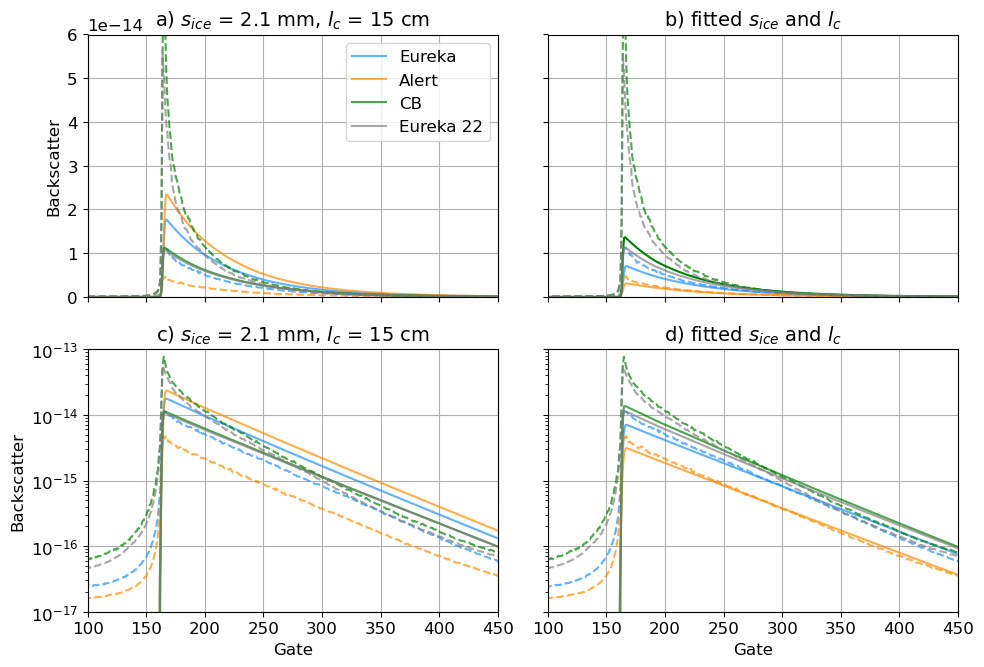

In [ ]:
# Plot results
plt.close()
plt.rcParams.update({'font.size': 12})
fig, ((ax1, ax2), (ax3, ax4))   = plt.subplots(nrows=2, ncols=2, figsize=(10,7), sharex=True, sharey = 'row')

#Eureka normf roughness
ax1.plot(mean_simu_E_roughNorm / cryosat_norm_factor , color = 'dodgerblue', alpha = 0.7, label='Eureka')
ax1.plot(mean_obs_E, 'b-', linestyle = '--', color = 'dodgerblue', alpha = 0.7)

#Alert normf roughness 
ax1.plot(mean_simu_A_roughNorm / cryosat_norm_factor, color = 'darkorange', alpha = 0.7, label='Alert')
ax1.plot(mean_obs_A, 'b-', linestyle = '--', color = 'darkorange', alpha = 0.7)

#CB normf roughness
ax1.plot(mean_simu_CB_roughNorm / cryosat_norm_factor, color = 'green', alpha = 0.7, label='CB')
ax1.plot(mean_obs_CB, 'b-', linestyle = '--', color = 'green', alpha = 0.7)

#E22 normf roughness
ax1.plot(mean_simu_E22_roughNorm / cryosat_norm_factor, color = 'grey', alpha = 0.7, label='Eureka 22')
ax1.plot(mean_obs_E22, 'b-', linestyle = '--', color = 'grey', alpha = 0.7)

ax1.set_ylabel('Backscatter', size = 12)
#ax1.set_yscale('log')
ax1.legend()
#ax1.set_xlim(0, 450)
ax1.set_ylim(0, 0.6e-13)
ax1.grid()




#Eureka optimized roughness
ax2.plot(mean_simu_E / cryosat_norm_factor, color = 'dodgerblue', alpha = 0.7)
ax2.plot(mean_obs_E, 'b-', linestyle = '--', color = 'dodgerblue', alpha = 0.7)

#Alert optimized roughness 
ax2.plot(mean_simu_A / cryosat_norm_factor, color = 'darkorange', alpha = 0.7 )
ax2.plot(mean_obs_A, 'b-', linestyle = '--', color = 'darkorange', alpha = 0.7)

#CB optimized roughness
ax2.plot(mean_simu_CB / cryosat_norm_factor, color = 'Green')
ax2.plot(mean_obs_CB, linestyle = '--', color = 'Green', alpha = 0.7)

#E22 optimized roughness
ax2.plot(mean_simu_E22 / cryosat_norm_factor, color = 'grey', alpha = 0.7, label='Eureka 22')
ax2.plot(mean_obs_E22, 'b-', linestyle = '--', color = 'grey', alpha = 0.7)

#ax2.set_yscale('log')
ax2.grid()
ax2.set_ylim(0, 0.6e-13)


#Eureka normf roughness
ax3.plot(mean_simu_E_roughNorm / cryosat_norm_factor , color = 'dodgerblue', alpha = 0.7, label='Eureka')
ax3.plot(mean_obs_E, 'b-', linestyle = '--', color = 'dodgerblue', alpha = 0.7)

#Alert normf roughness 
ax3.plot(mean_simu_A_roughNorm / cryosat_norm_factor, color = 'darkorange', alpha = 0.7, label='Alert')
ax3.plot(mean_obs_A, 'b-', linestyle = '--', color = 'darkorange', alpha = 0.7)

#CB normf roughness
ax3.plot(mean_simu_CB_roughNorm / cryosat_norm_factor, color = 'green', alpha = 0.7, label='CB')
ax3.plot(mean_obs_CB, 'b-', linestyle = '--', color = 'green', alpha = 0.7)

#E22 normf roughness
ax3.plot(mean_simu_E22_roughNorm / cryosat_norm_factor, color = 'grey', alpha = 0.7, label='Eureka 22')
ax3.plot(mean_obs_E22, 'b-', linestyle = '--', color = 'grey', alpha = 0.7)

ax3.set_ylabel('Backscatter', size = 12)
ax3.set_yscale('log')
#ax3.legend()
#ax3.set_xlim(0, 450)
ax3.set_ylim(0, 0.6e-13)
ax3.set_xlabel('Gate')
ax3.grid()




#Eureka  optimized roughness
ax4.plot(mean_simu_E / cryosat_norm_factor , color = 'dodgerblue', alpha = 0.7, label='Eureka')
ax4.plot(mean_obs_E, 'b-', linestyle = '--', color = 'dodgerblue', alpha = 0.7)

#Alert  optimized roughness
ax4.plot(mean_simu_A / cryosat_norm_factor, color = 'darkorange', alpha = 0.7, label='Alert')
ax4.plot(mean_obs_A, 'b-', linestyle = '--', color = 'darkorange', alpha = 0.7)

#CB  optimized roughness
ax4.plot(mean_simu_CB / cryosat_norm_factor, color = 'green', alpha = 0.7, label='CB')
ax4.plot(mean_obs_CB, 'b-', linestyle = '--', color = 'green', alpha = 0.7)

#E22 optimized roughness
ax4.plot(mean_simu_E22 / cryosat_norm_factor, color = 'grey', alpha = 0.7, label='Eureka 22')
ax4.plot(mean_obs_E22, 'b-', linestyle = '--', color = 'grey', alpha = 0.7)

#ax4.set_ylabel('Backscatter', size = 12)
ax4.set_xlabel('Gate')
ax4.set_yscale('log')
ax4.set_ylim(1e-17, 1e-13)
ax4.grid()



ax1.set_title('a) $s_{ice}$ = 2.1 mm, $l_c$ = 15 cm', size = 14)
ax3.set_title('c) $s_{ice}$ = 2.1 mm, $l_c$ = 15 cm', size = 14)

ax2.set_title('b) fitted $s_{ice}$ and $l_c$ ', size = 14)
ax4.set_title('d) fitted $s_{ice}$ and $l_c$ ', size = 14)


ax1.set_xlim(100, 450)
plt.tight_layout()
#plt.savefig('C://Users/julie/OneDrive - USherbrooke/post-doc/AKROSS/article/fig_output/sites_waveform_rough_opti_incsample.png', dpi=300, format='png', bbox_inches='tight')